In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import time
from numba import jit, prange
import os
import warnings

2025-03-24 19:55:08.956726: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
tf.random.set_seed(1234)
np.random.seed(1234)

In [4]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.2


In [5]:
# Use Numba to accelerate data preprocessing
@jit(nopython=True, parallel=True)
def normalize_data(data, min_val, max_val):
    """Normalize data in parallel using Numba."""
    return (data - min_val) / (max_val - min_val)

@jit(nopython=True)
def create_collocation_points(n_points, min_val=0.0, max_val=1.0):
    """Generate collocation points efficiently."""
    return np.random.uniform(min_val, max_val, (n_points, 1))

In [6]:
bobcat_df = pd.read_csv('cleaned_bobcat_data.csv')
rabbit_df = pd.read_csv('cleaned_rabbit_data.csv')
print("Data loaded successfully")

Data loaded successfully


In [7]:
# Extract time points and population data
t_data = np.array(bobcat_df.index)
x_data = np.array(bobcat_df[' Bobcats'])  # Bobcat population
y_data = np.array(rabbit_df[' Rabbits'])  # Rabbit population

In [8]:
# Normalize data
t_min, t_max = t_data.min(), t_data.max()
x_min, x_max = np.nanmin(x_data), np.nanmax(x_data)
y_min, y_max = np.nanmin(y_data), np.nanmax(y_data)

In [9]:
# Use Numba to speed up normalization
t_data_norm = normalize_data(t_data, t_min, t_max)
x_data_norm = np.array([(x - x_min) / (x_max - x_min) if not np.isnan(x) else np.nan for x in x_data])
y_data_norm = normalize_data(y_data, y_min, y_max)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [10]:
# Prepare observed data, handling NaNs
observed_data = []
for i in range(len(t_data)):
    if not (np.isnan(x_data_norm[i]) or np.isnan(y_data_norm[i])):
        observed_data.append([t_data_norm[i], x_data_norm[i], y_data_norm[i]])

observed_data = np.array(observed_data)
print(f"Observed data points: {len(observed_data)}")

Observed data points: 91


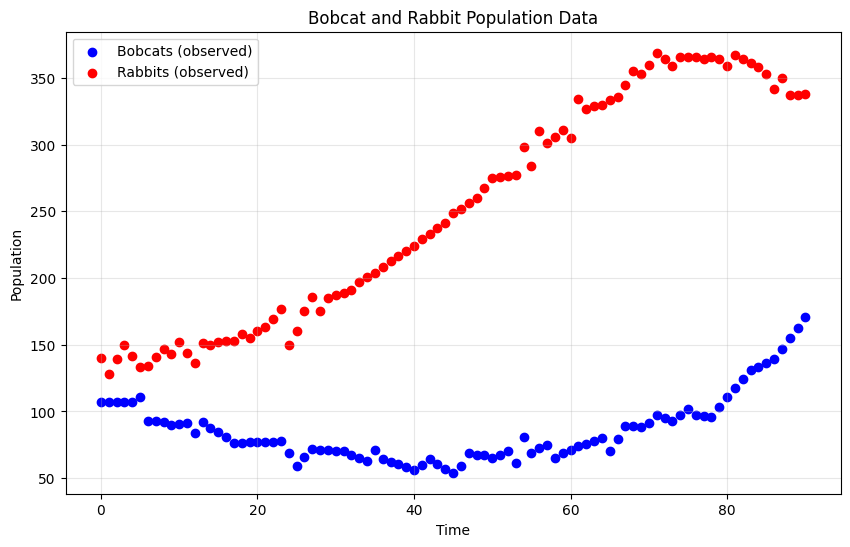

In [11]:
# Visualize the data before modeling
plt.figure(figsize=(10, 6))
plt.scatter(t_data, x_data, c='blue', label='Bobcats (observed)')
plt.scatter(t_data, y_data, c='red', label='Rabbits (observed)')
plt.title('Bobcat and Rabbit Population Data')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [12]:
# Build the PINN model
def build_pinn(neurons=32, layers=3, activation='swish'):
    """Build an optimized PINN model."""
    # Neural network for predicting [x, y] from time t
    t_input = Input(shape=(1,))
    h = t_input
    
    # Create hidden layers with better initialization
    for i in range(layers):
        h_prev = h
        h = Dense(neurons, activation=activation, 
                 kernel_initializer='he_normal',
                 kernel_regularizer=tf.keras.regularizers.l2(1e-4))(h)
        
        # Add residual connection every 2 layers (except first)
        if i > 0 and i % 2 == 0 and i < layers-1:
            h = tf.keras.layers.add([h, h_prev])
    
    output = Dense(2)(h)  # [x, y] - Bobcat and Rabbit populations
    
    # Create model
    model = Model(inputs=t_input, outputs=output)
    return model

In [13]:
# Create the model
pinn = build_pinn(neurons=32, layers=3)
pinn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,242 (8.76 KB)

 Trainable params: 2,242 (8.76 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Define trainable Lotka-Volterra parameters
a = tf.Variable(0.4, dtype=tf.float32, name='a')  # Growth rate of rabbits
b = tf.Variable(0.01, dtype=tf.float32, name='b')  # Effect of predation on rabbits
c = tf.Variable(0.3, dtype=tf.float32, name='c')  # Natural death rate of bobcats
d = tf.Variable(0.01, dtype=tf.float32, name='d')  # Conversion of predation to bobcat growth

In [15]:
# Define physics-informed residual
@tf.function
def lotka_volterra_residual(t):
    """Calculate residual of Lotka-Volterra equations."""
    with tf.GradientTape() as tape:
        tape.watch(t)
        xy = pinn(t)
    
    dxy_dt = tape.gradient(xy, t)
    
    # Extract components
    x = xy[:, 0:1]  # Bobcat population
    y = xy[:, 1:2]  # Rabbit population
    dx_dt = dxy_dt[:, 0:1]
    dy_dt = dxy_dt[:, 1:2]
    
    # Lotka-Volterra equations
    # dx/dt = a*x - b*x*y
    # dy/dt = -c*y + d*x*y
    f_x = a*x - b*x*y - dx_dt
    f_y = -c*y + d*x*y - dy_dt
    
    return f_x, f_y

In [16]:
# Optimized training step
@tf.function
def train_step(t_obs, xy_obs, t_collocation, physics_weight=1.0, noise_level=0.01):
    """Perform one training step with robustness improvements."""
    # Add small noise for improved generalization
    t_obs_noisy = t_obs + tf.random.normal(t_obs.shape, mean=0.0, stddev=noise_level)
    
    with tf.GradientTape() as tape:
        # Data loss - compare predictions to observations
        xy_pred_obs = pinn(t_obs_noisy)
        bobcat_loss = tf.reduce_mean(tf.square(xy_pred_obs[:, 0:1] - xy_obs[:, 0:1]))
        rabbit_loss = tf.reduce_mean(tf.square(xy_pred_obs[:, 1:2] - xy_obs[:, 1:2]))
        data_loss = bobcat_loss + rabbit_loss
        
        # Physics loss - ensure predictions satisfy Lotka-Volterra equations
        f_x, f_y = lotka_volterra_residual(t_collocation)
        physics_loss = tf.reduce_mean(tf.square(f_x) + tf.square(f_y))
        
        # Parameter regularization to keep values biologically plausible
        param_reg = tf.reduce_sum(tf.square(a) + tf.square(b) + tf.square(c) + tf.square(d)) * 1e-4
        
        # Total loss with weighted physics component
        total_loss = data_loss + physics_weight * physics_loss + param_reg
    
    # Compute gradients
    variables = pinn.trainable_variables + [a, b, c, d]
    gradients = tape.gradient(total_loss, variables)
    
    # Gradient clipping to prevent instability
    gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]
    
    # Apply gradients
    optimizer.apply_gradients(zip(gradients, variables))
    
    return total_loss, data_loss, physics_loss

In [17]:
# Setup for training
# Create tensors for observed data
t_obs = tf.convert_to_tensor(observed_data[:, 0:1], dtype=tf.float32)
xy_obs = tf.convert_to_tensor(observed_data[:, 1:3], dtype=tf.float32)

In [18]:
# Create collocation points
n_collocation = 1000
t_collocation_np = create_collocation_points(n_collocation)
t_collocation = tf.convert_to_tensor(t_collocation_np, dtype=tf.float32)

In [19]:
# Initialize optimizer with cosine decay for better convergence
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate=0.001,
    first_decay_steps=1000,
    t_mul=2.0,
    m_mul=0.9,
    alpha=0.0001
)
optimizer = Adam(learning_rate=lr_schedule)

In [20]:
# Training loop with early stopping
max_epochs = 8000
patience = 500
min_delta = 1e-6
best_loss = float('inf')
wait = 0
history = {'loss': [], 'data_loss': [], 'physics_loss': []}


In [21]:
# Initialize progress tracking
print(f"Starting training for up to {max_epochs} epochs...")
start_time = time.time()

Starting training for up to 8000 epochs...


In [22]:
# Adaptive physics weight
physics_weight = 0.1  # Start with lower weight on physics loss

# Define checkpoint interval
checkpoint_interval = 500  # Visualize progress every 500 epochs

for epoch in range(max_epochs):
    # Increase physics weight gradually
    if epoch % 500 == 0 and epoch > 0:
        physics_weight = min(1.0, physics_weight * 1.5)
    
    # Reduce noise over time
    noise_level = max(0.001, 0.01 * (1.0 - epoch/max_epochs))
    
    loss, data_loss, physics_loss = train_step(t_obs, xy_obs, t_collocation, 
                                              physics_weight, noise_level)
    
    # Record losses
    history['loss'].append(loss.numpy())
    history['data_loss'].append(data_loss.numpy())
    history['physics_loss'].append(physics_loss.numpy())
    
    # Progress reporting (less frequent for speed)
    if epoch % 200 == 0:
        elapsed = time.time() - start_time
        print(f"Epoch {epoch}/{max_epochs}: loss={loss:.4f}, data_loss={data_loss:.4f}, "
              f"physics_loss={physics_loss:.4f}, time={elapsed:.1f}s")
    
    # Checkpoint visualization - add this block
    if epoch % checkpoint_interval == 0 and epoch > 0:
        # Create sample time points for visualization
        t_sample = np.linspace(0, 1, 50).reshape(-1, 1)
        t_sample_tensor = tf.convert_to_tensor(t_sample, dtype=tf.float32)
        
        # Get predictions at current training stage
        xy_pred = pinn(t_sample_tensor).numpy()
        
        # Denormalize for plotting
        t_sample_denorm = t_sample * (t_max - t_min) + t_min
        x_pred_denorm = xy_pred[:, 0] * (x_max - x_min) + x_min
        y_pred_denorm = xy_pred[:, 1] * (y_max - y_min) + y_min
        
        # Create checkpoint visualization
        plt.figure(figsize=(10, 6))
        plt.plot(t_sample_denorm, x_pred_denorm, 'b-', label='PINN Bobcats')
        plt.plot(t_sample_denorm, y_pred_denorm, 'r-', label='PINN Rabbits')
        
        # Plot actual data points
        valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
        plt.scatter(t_data[valid_indices], x_data[valid_indices], 
                   c='blue', alpha=0.7, label='Bobcats Data')
        plt.scatter(t_data[valid_indices], y_data[valid_indices], 
                   c='red', alpha=0.7, label='Rabbits Data')
        
        plt.title(f'Training Progress - Epoch {epoch}')
        plt.xlabel('Time')
        plt.ylabel('Population')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Optional: also show current parameter values
        print(f"Current parameters at epoch {epoch}:")
        print(f"a={a.numpy():.4f}, b={b.numpy():.4f}, c={c.numpy():.4f}, d={d.numpy():.4f}")
    
    # Early stopping check
    if loss < best_loss - min_delta:
        best_loss = loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

Epoch 0/8000: loss=nan, data_loss=0.8831, physics_loss=nan, time=2.4s
Epoch 200/8000: loss=nan, data_loss=0.0073, physics_loss=nan, time=161.2s
Epoch 400/8000: loss=nan, data_loss=0.0051, physics_loss=nan, time=331.0s
Early stopping at epoch 499


In [23]:
# Report final training time
total_time = time.time() - start_time
print(f"Training completed in {total_time:.2f} seconds ({epoch+1} epochs)")
print(f"Final parameters: a={a.numpy():.4f}, b={b.numpy():.4f}, c={c.numpy():.4f}, d={d.numpy():.4f}")

Training completed in 433.42 seconds (500 epochs)
Final parameters: a=0.0984, b=-0.0000, c=0.0376, d=-0.0000


In [24]:
# Generate predictions with batching for efficiency
def predict_in_batches(t_points, batch_size=1000):
    """Generate predictions in batches to avoid memory issues."""
    n_points = len(t_points)
    predictions = np.zeros((n_points, 2))
    
    for i in range(0, n_points, batch_size):
        batch_end = min(i + batch_size, n_points)
        batch = t_points[i:batch_end]
        batch_tensor = tf.convert_to_tensor(batch, dtype=tf.float32)
        predictions[i:batch_end] = pinn(batch_tensor).numpy()
    
    return predictions

In [25]:
# Generate normalized time points for evaluation (more points for smoother curves)
t_eval_norm = np.linspace(0, 1, 200).reshape(-1, 1)
# Predict in batches
xy_pred_norm = predict_in_batches(t_eval_norm)

In [26]:
# Denormalize predictions
t_eval = t_eval_norm * (t_max - t_min) + t_min
x_pred = xy_pred_norm[:, 0] * (x_max - x_min) + x_min
y_pred = xy_pred_norm[:, 1] * (y_max - y_min) + y_min

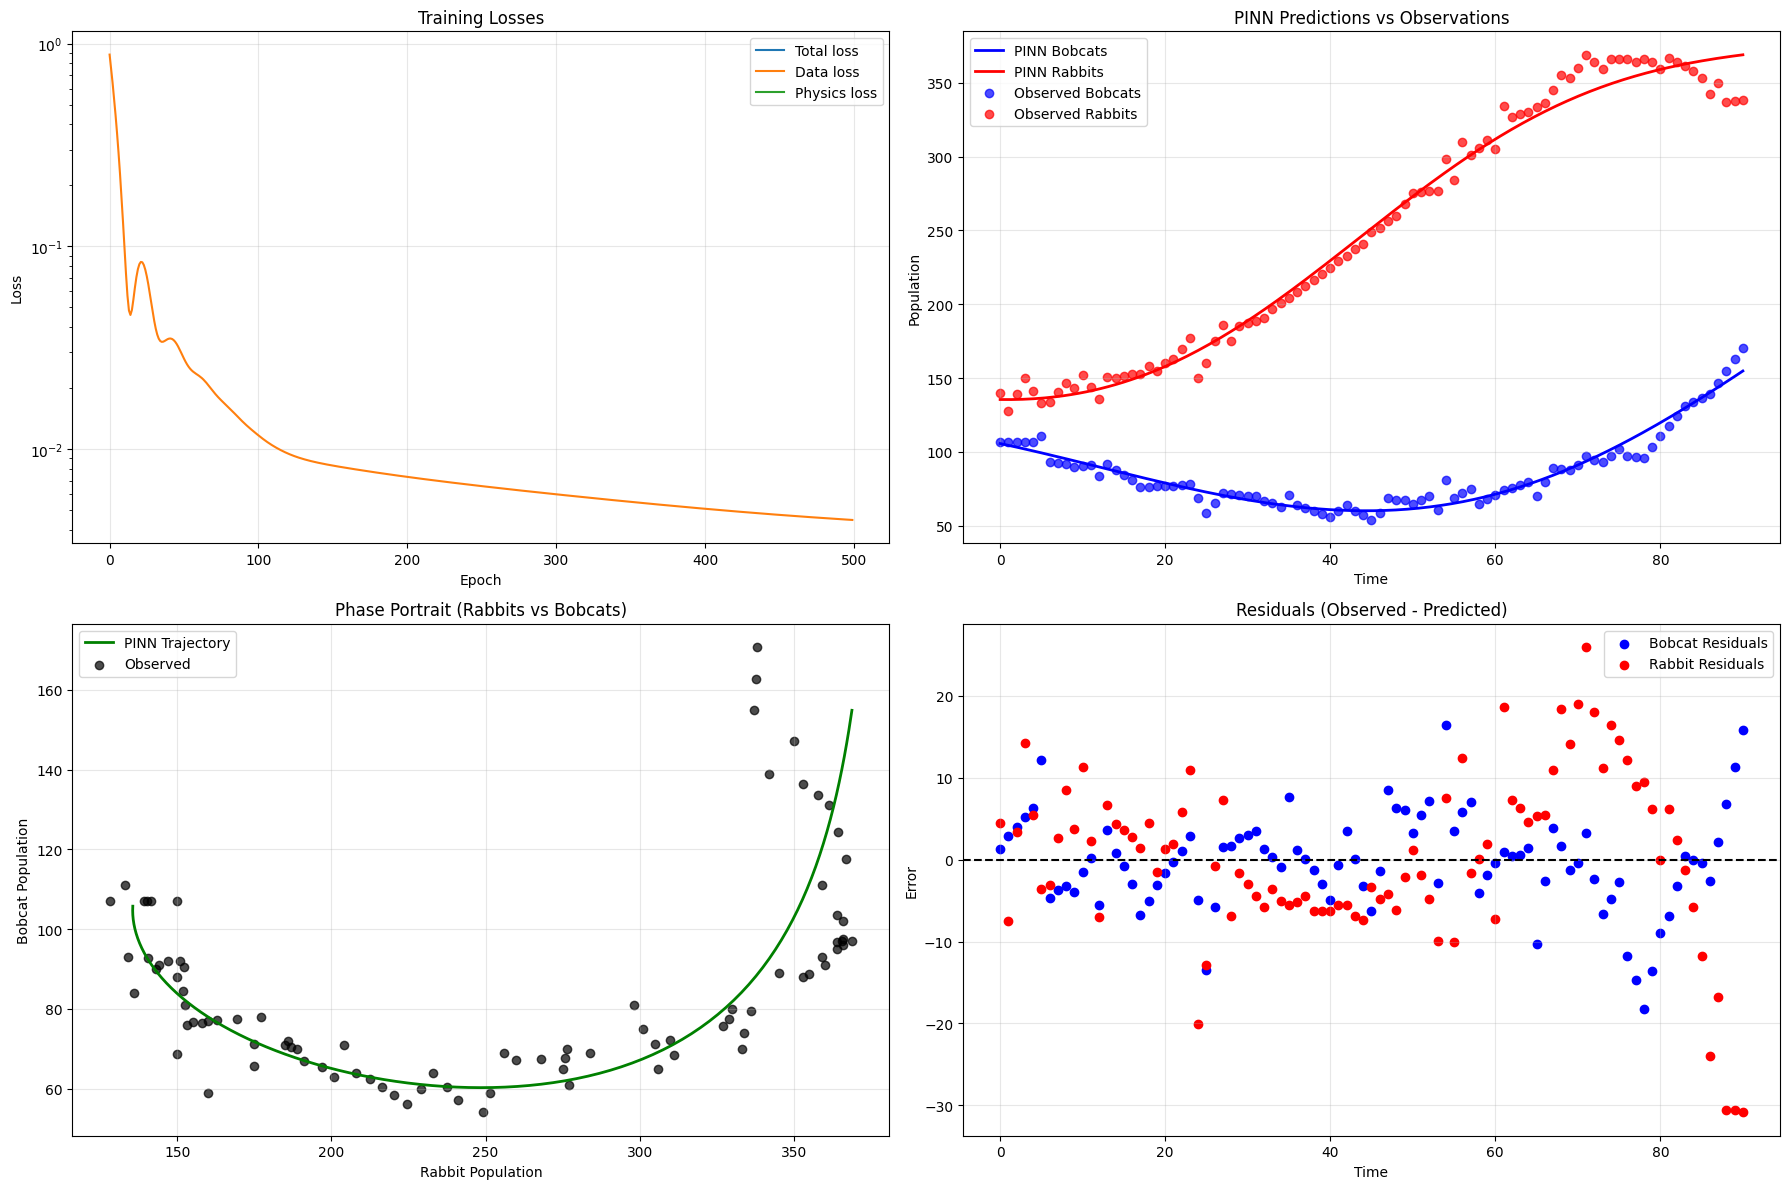

In [27]:
# Plot results - comprehensive visualization
plt.figure(figsize=(18, 12))

# Plot 1: Training losses
plt.subplot(2, 2, 1)
plt.semilogy(history['loss'], label='Total loss')
plt.semilogy(history['data_loss'], label='Data loss')
plt.semilogy(history['physics_loss'], label='Physics loss')
plt.legend()
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot 2: Predicted vs actual populations
plt.subplot(2, 2, 2)
plt.plot(t_eval, x_pred, 'b-', label='PINN Bobcats', linewidth=2)
plt.plot(t_eval, y_pred, 'r-', label='PINN Rabbits', linewidth=2)
plt.scatter(t_data, x_data, c='blue', marker='o', alpha=0.7, label='Observed Bobcats')
plt.scatter(t_data, y_data, c='red', marker='o', alpha=0.7, label='Observed Rabbits')
plt.title('PINN Predictions vs Observations')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 3: Phase portrait
plt.subplot(2, 2, 3)
plt.plot(y_pred, x_pred, 'g-', label='PINN Trajectory', linewidth=2)
valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
plt.scatter(y_data[valid_indices], x_data[valid_indices], c='black', label='Observed', alpha=0.7)
plt.title('Phase Portrait (Rabbits vs Bobcats)')
plt.xlabel('Rabbit Population')
plt.ylabel('Bobcat Population')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Residuals
plt.subplot(2, 2, 4)
valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
t_valid = t_data[valid_indices]
x_valid = x_data[valid_indices]
y_valid = y_data[valid_indices]

interp_indices = np.searchsorted(t_eval.flatten(), t_valid)
x_residuals = x_valid - x_pred[interp_indices]
y_residuals = y_valid - y_pred[interp_indices]

plt.scatter(t_valid, x_residuals, c='blue', label='Bobcat Residuals')
plt.scatter(t_valid, y_residuals, c='red', label='Rabbit Residuals')
plt.axhline(y=0, color='k', linestyle='--')
plt.title('Residuals (Observed - Predicted)')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

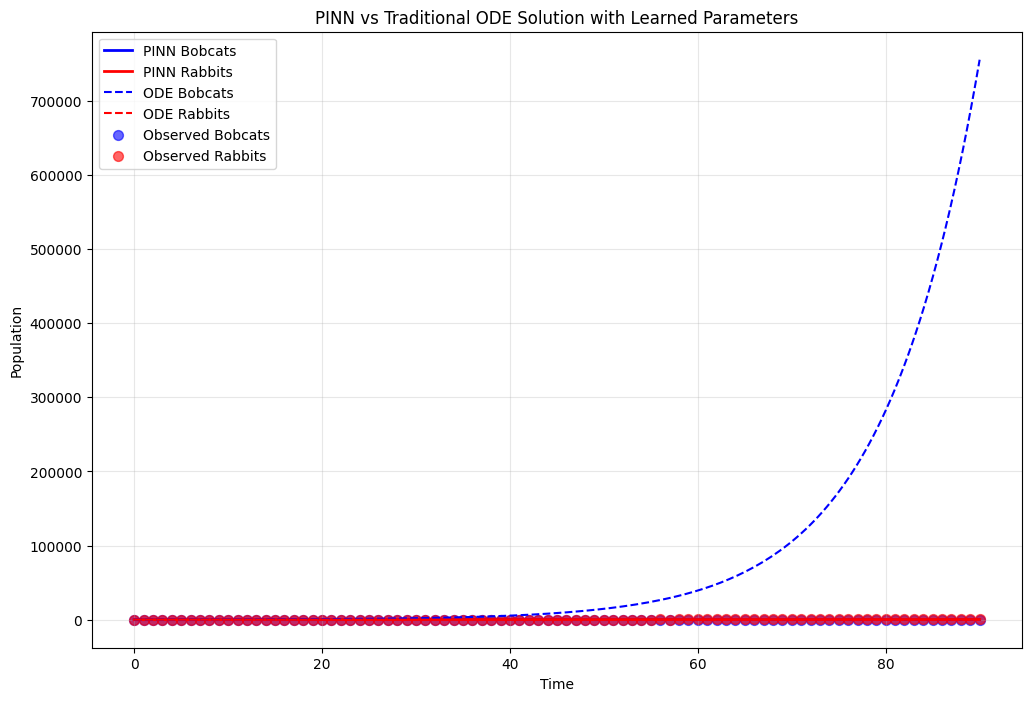

In [28]:
# Additional visualization: Compare with traditional ODE solution
from scipy.integrate import solve_ivp

def lotka_volterra_ode(t, z):
    """Traditional Lotka-Volterra ODE function using learned parameters."""
    x, y = z
    dx_dt = a.numpy() * x - b.numpy() * x * y
    dy_dt = -c.numpy() * y + d.numpy() * x * y
    return [dx_dt, dy_dt]

# Find first valid data point for initial conditions
valid_idx = np.where(~np.isnan(x_data) & ~np.isnan(y_data))[0][0]
init_conditions = [x_data[valid_idx], y_data[valid_idx]]
init_time = t_data[valid_idx]

# Solve using scipy
solution = solve_ivp(
    lotka_volterra_ode,
    [init_time, t_max],
    init_conditions,
    method='LSODA',
    t_eval=t_eval.flatten()
)

# Compare PINN with traditional ODE solution
plt.figure(figsize=(12, 8))
plt.plot(t_eval, x_pred, 'b-', label='PINN Bobcats', linewidth=2)
plt.plot(t_eval, y_pred, 'r-', label='PINN Rabbits', linewidth=2)
plt.plot(t_eval, solution.y[0], 'b--', label='ODE Bobcats', linewidth=1.5)
plt.plot(t_eval, solution.y[1], 'r--', label='ODE Rabbits', linewidth=1.5)
plt.scatter(t_data, x_data, c='blue', marker='o', alpha=0.6, s=50, label='Observed Bobcats')
plt.scatter(t_data, y_data, c='red', marker='o', alpha=0.6, s=50, label='Observed Rabbits')
plt.title('PINN vs Traditional ODE Solution with Learned Parameters')
plt.xlabel('Time')
plt.ylabel('Population')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [35]:
# Print metrics and learned model parameters
print("Lotka-Volterra Parameters Learned by PINN:")
print(f"a (rabbit growth rate): {a.numpy():.4f}")
print(f"b (predation effect on rabbits): {b.numpy():.4f}")
print(f"c (bobcat death rate): {c.numpy():.4f}")
print(f"d (predation benefit to bobcats): {d.numpy():.4f}")

Lotka-Volterra Parameters Learned by PINN:
a (rabbit growth rate): 0.0984
b (predation effect on rabbits): -0.0000
c (bobcat death rate): 0.0376
d (predation benefit to bobcats): -0.0000


In [30]:
# Calculate metrics
valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
t_valid = t_data[valid_indices]
x_valid = x_data[valid_indices]
y_valid = y_data[valid_indices]

interp_indices = np.searchsorted(t_eval.flatten(), t_valid)
x_pred_at_valid = x_pred[interp_indices]
y_pred_at_valid = y_pred[interp_indices]

In [31]:
# RMSE calculation
x_rmse = np.sqrt(np.mean((x_valid - x_pred_at_valid)**2))
y_rmse = np.sqrt(np.mean((y_valid - y_pred_at_valid)**2))

# R^2 calculation
x_ss_total = np.sum((x_valid - np.mean(x_valid))**2)
y_ss_total = np.sum((y_valid - np.mean(y_valid))**2)
x_ss_res = np.sum((x_valid - x_pred_at_valid)**2)
y_ss_res = np.sum((y_valid - y_pred_at_valid)**2)
x_r2 = 1 - (x_ss_res / x_ss_total)
y_r2 = 1 - (y_ss_res / y_ss_total)

In [34]:
print("Model Performance Metrics:")
print(f"Bobcat RMSE: {x_rmse:.2f}")
print(f"Rabbit RMSE: {y_rmse:.2f}")
print(f"Bobcat R²: {x_r2:.4f}")
print(f"Rabbit R²: {y_r2:.4f}")

Model Performance Metrics:
Bobcat RMSE: 5.93
Rabbit RMSE: 10.49
Bobcat R²: 0.9430
Rabbit R²: 0.9846


In [33]:
# Save model if needed
# pinn.save('lotka_volterra_pinn_model')

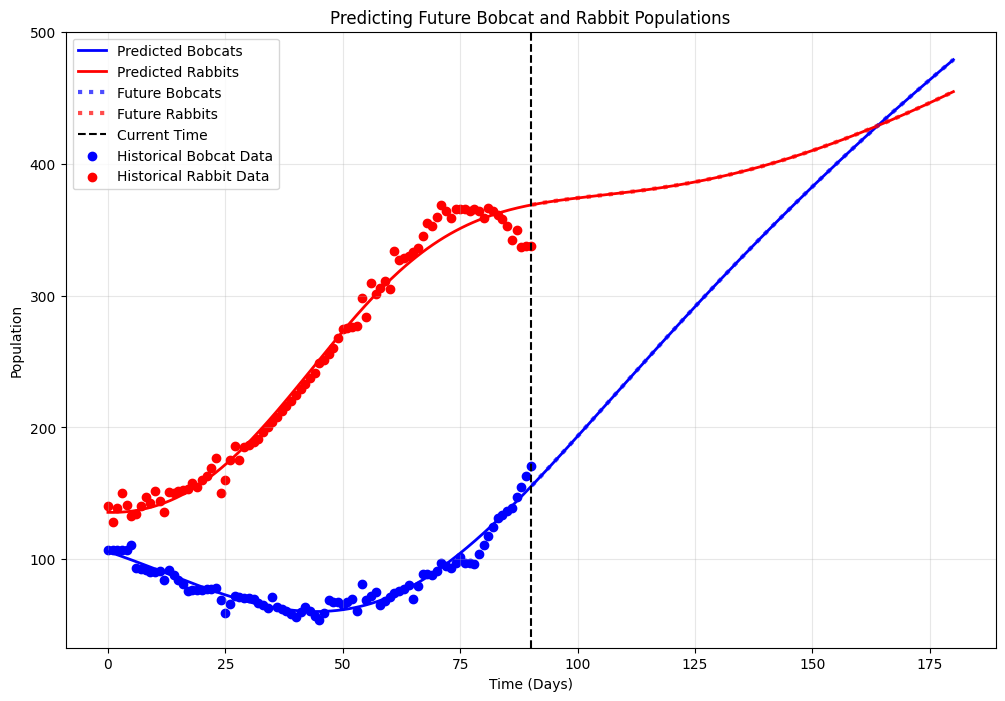


Future Population Predictions (PINN):
Days from now | Bobcats | Rabbits
---------------------------------
            5 |   174.3 |   372.0
           10 |   193.1 |   374.2
           20 |   233.7 |   378.4
           30 |   271.6 |   383.2
           60 |   382.5 |   410.1
           90 |   479.2 |   455.0


In [39]:
# FUTURE POPULATION PREDICTION

# Define how far into the future you want to predict (in same units as your data)
future_days = 90  # Predict 90 days into the future

# Create time array that includes both original and future time points
t_max_original = t_max
t_future_max = t_max_original + future_days

# Create extended normalized time array (0 to 1 scale)
future_time_factor = t_future_max / (t_max_original - t_min)
t_extended_norm = np.linspace(0, t_future_max/(t_max_original-t_min), 300).reshape(-1, 1)

# Use the model to predict for all time points including future
xy_pred_extended = predict_in_batches(t_extended_norm)

# Denormalize predictions to original scale
t_extended = t_extended_norm.flatten() * (t_max_original - t_min) + t_min  # Flatten to make it 1D
x_pred_extended = xy_pred_extended[:, 0] * (x_max - x_min) + x_min
y_pred_extended = xy_pred_extended[:, 1] * (y_max - y_min) + y_min

# Visualize with future predictions
plt.figure(figsize=(12, 8))

# Plot historical + future predictions
plt.plot(t_extended, x_pred_extended, 'b-', label='Predicted Bobcats', linewidth=2)
plt.plot(t_extended, y_pred_extended, 'r-', label='Predicted Rabbits', linewidth=2)

# Highlight the future predictions
future_indices = t_extended > t_max_original
plt.plot(t_extended[future_indices], x_pred_extended[future_indices], 'b:', linewidth=3, alpha=0.7, label='Future Bobcats')
plt.plot(t_extended[future_indices], y_pred_extended[future_indices], 'r:', linewidth=3, alpha=0.7, label='Future Rabbits')

# Add vertical line separating historical data from future predictions
plt.axvline(x=t_max_original, color='k', linestyle='--', label='Current Time')

# Plot actual historical data points
valid_indices = ~np.isnan(x_data) & ~np.isnan(y_data)
plt.scatter(t_data[valid_indices], x_data[valid_indices], c='blue', marker='o', label='Historical Bobcat Data')
plt.scatter(t_data[valid_indices], y_data[valid_indices], c='red', marker='o', label='Historical Rabbit Data')

plt.title('Predicting Future Bobcat and Rabbit Populations')
plt.xlabel('Time (Days)')
plt.ylabel('Population')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print specific future population predictions
future_points = [5, 10, 20, 30, 60, 90]  # Days into the future
print("\nFuture Population Predictions (PINN):")
print("Days from now | Bobcats | Rabbits")
print("---------------------------------")

for days in future_points:
    future_time = t_max_original + days
    # Find closest index in the predicted time array
    idx = np.abs(t_extended - future_time).argmin()
    print(f"{days:13d} | {x_pred_extended[idx]:7.1f} | {y_pred_extended[idx]:7.1f}")